# Creating all figures

***

Jan T. Schleicher, 2024

In this notebook, we generate all main and supplementary figures from Gupta et al. 2024.

## Main figures

In [1]:
import os
import sys

import numpy as np
np.random.seed(42)
import pandas as pd

import scvelo as scv
import scanpy as sc

import cy2path as c2p
from scipy.cluster import hierarchy

from scipy import sparse
from scipy import stats
from statsmodels.stats.multitest import multipletests

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patheffects as pe
import skunk
import networkx as nx
import string

sys.path.append("../utils/")
from gridplot import make_grid

sc.set_figure_params(vector_friendly=True, dpi_save=300, scanpy=False, frameon=False, fontsize=10)
scv.set_figure_params(vector_friendly=True, dpi_save=300, frameon=False, fontsize=10)

plt.style.use("../utils/matplotlibrc.txt")

%config Completer.use_jedi = False

In [2]:
DATA_PATH = "../data/"
FIGURE_PATH = "../figures/"
os.makedirs(FIGURE_PATH, exist_ok=True)

In [3]:
adata = sc.read_h5ad(os.path.join(DATA_PATH, "tex_data_chronic_cytopath.h5ad"))

In [4]:
adata.obs.timepoint = adata.obs.timepoint.str.replace("_2_3_", "-")
adata.obs.timepoint = adata.obs.timepoint.astype("category")
adata.obs.timepoint = adata.obs.timepoint.cat.reorder_categories(["d1-4", "d7", "d14", "d21"])
adata.uns["timepoint_colors"] = np.asarray(["#2b83ba", "#abdda4", "#fdae61", "#d7191c"], dtype="object")
adata.obs["annotation"] = adata.obs.annot.map({"early": "early", "prolif": "proliferating",
                                               "int_exh": "intermediate exhausted",
                                               "eff_like": "effector-like exhausted",
                                               "term_exh": "terminally exhausted",
                                               "mem_like": "memory-like exhausted"})

In [5]:
axlab_kws = {"fontsize": 12, "fontweight": "bold", "va": "bottom", "ha": "left"}
fig_width = 7.5

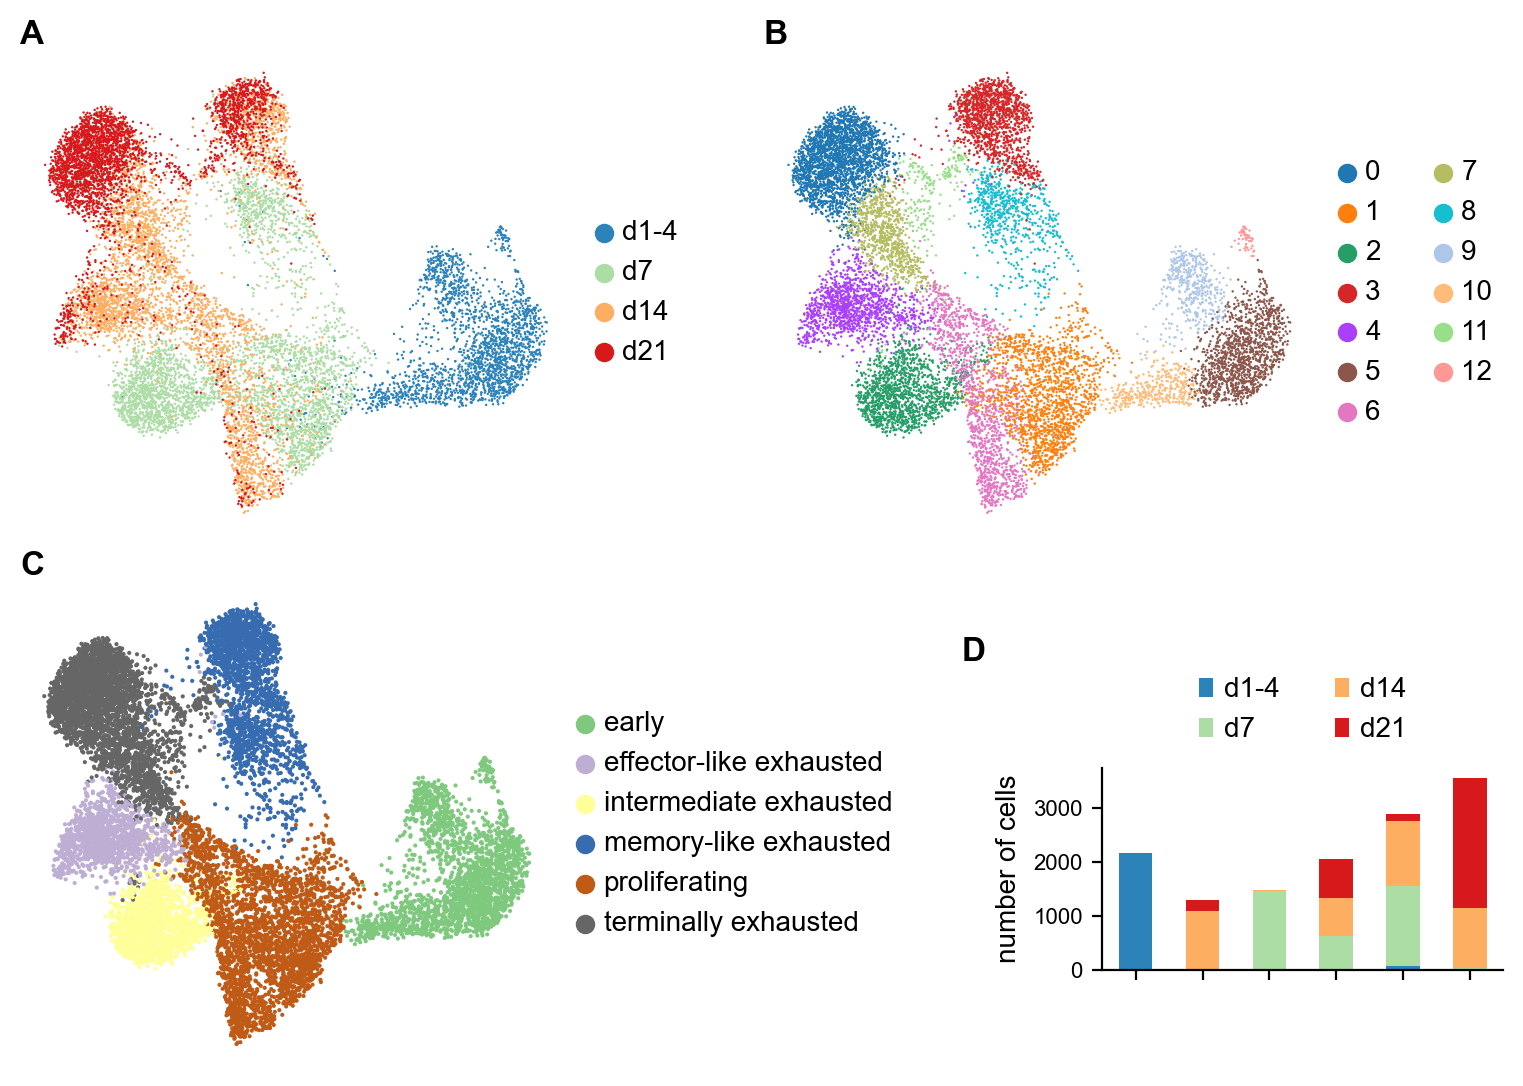

In [6]:
# Figure 2
fig, axs = make_grid((fig_width, fig_width/12*8.5),
                     {"nrows": 2, "ncols": 1, "row_heights": [1, 1], "col_widths": [1],
                      "sub_grids": [
                          {"nrows": 1, "ncols": 2, "row_heights": [1], "col_widths": [1, 1],
                           "wspace": 0.1},
                          {"nrows": 1, "ncols": 2, "row_heights": [1], "col_widths": [1, 1],
                           "wspace": 0.2, "sub_grids": [
                               None,
                               {"nrows": 3, "ncols": 1, "row_heights": [1, 3, 1], "col_widths": [1]}
                           ]}
                      ]})

sc.pl.umap(adata, color="timepoint", ax=axs[0], title="",
           show=False, s=3)
axs[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

sc.pl.umap(adata, color="leiden", ax=axs[1], title="",
           show=False, s=3)
axs[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=2)

sc.pl.umap(adata, color="annotation", ax=axs[2], title="",
           palette="Accent", show=False)
axs[2].legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)

axs[3].set_visible(False)

adata.obs.groupby(["annotation", "timepoint"]).size().unstack().plot.bar(
    stacked=True, rot=45, ax=axs[4], color=adata.uns["timepoint_colors"]
)
axs[4].set_xticklabels(labels=axs[5].get_xticklabels(), ha="right")
axs[4].legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=2)
axs[4].set_ylabel("number of cells")
axs[4].set_yticklabels([0, 1000, 2000, 3000])
axs[4].set_xlabel("")

axs[5].set_visible(False)

for i, label in enumerate(string.ascii_uppercase[:3]):
    axs[i].text(0, 1.0, label, transform=axs[i].transAxes, **axlab_kws)
axs[4].text(-0.35, 1.5, "D", transform=axs[4].transAxes, **axlab_kws)

fig.savefig(os.path.join(FIGURE_PATH, "fig_02.png"))

In [7]:
# Known marker genes of exhausted T cell subpopulations
marker_genes_dict = {"early": ["Icos", "Cdk2", "Sell"],
                     "memory-like exhausted": ["Il7r", "Tcf7", "Slamf6"],
                     "proliferating": ["Mki67", "Cdca8"],
                     "intermediate exhausted": ["Gzmb", "Bcl2l11", "Anxa1", "Pdcd1"],
                     "effector-like exhausted": ["Cx3cr1", "Klre1", "Klra3", "Klrg1"],
                     "terminally exhausted": ["Cxcr6", "Cd160", "Eomes", "Tox", "Lag3", "Entpd1"]}

In [8]:
marker_genes = [m for l in marker_genes_dict.values() for m in l]
matrixplot_df = pd.DataFrame(columns=marker_genes,
                             index=adata.obs.annotation.cat.categories, dtype=float)
for clust in adata.obs.annotation.cat.categories:
    matrixplot_df.loc[clust] = adata[adata.obs.annotation == clust, marker_genes].layers["log1p"].mean(axis=0)
matrixplot_df = matrixplot_df.div(matrixplot_df.sum(axis=0), axis=1)
matrixplot_df = matrixplot_df.loc[["early", "memory-like exhausted", "proliferating", "intermediate exhausted",
                                   "effector-like exhausted", "terminally exhausted"], :]

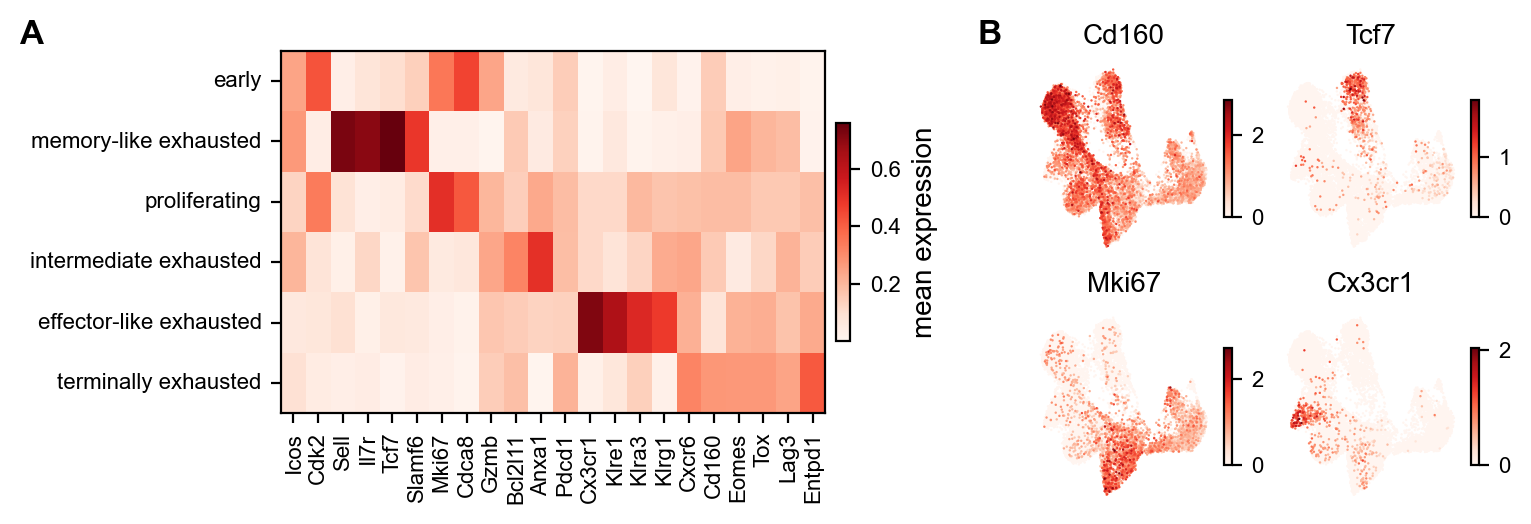

In [9]:
# Figure 3
cmap_exp = "Reds"

fig, axs = make_grid((fig_width, fig_width/3),
                     {"nrows": 1, "ncols": 2, "row_heights": [1], "col_widths": [1, 1],
                      "sub_grids": [
                          None,
                          {"nrows": 2, "ncols": 2, "row_heights": [1, 1], "col_widths": [1, 1]}
                      ], "wspace": .1})

# mean expression heatmap
sns.heatmap(matrixplot_df, cmap=cmap_exp, ax=axs[0], square=False, cbar=False)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, ha="center")
axs[0].set_yticklabels(axs[0].get_yticklabels())
for _, spine in axs[0].spines.items():
    spine.set_visible(True)
plt.colorbar(axs[0].get_children()[0], ax=axs[0], ticks=[0, .2, .4, .6, .8], label="mean expression",
             shrink=.6, aspect=15, pad=.02)

# expression of selected marker genes on UMAP
for i, gene in enumerate(["Cd160", "Tcf7", "Mki67", "Cx3cr1"]):
    sc.pl.umap(adata, color=gene, ax=axs[i+1], cmap=cmap_exp, layer="log1p",
               show=False, colorbar_loc=None, s=3)
    plt.colorbar(axs[i+1].get_children()[0], ax=axs[i+1], shrink=.6, aspect=15)
    
axs[0].text(-.48, 1.0, "A", transform=axs[0].transAxes, **axlab_kws)
axs[1].text(-.3, 1.05, "B", transform=axs[1].transAxes, **axlab_kws)
fig.savefig(os.path.join(FIGURE_PATH, "fig_03.png"));

In [10]:
adata.obs[["average_step_exh", "average_step_mem"]] = adata.uns["trajectories"]["step_time"].T
adata.obs[["fate_prob_exh", "fate_prob_mem"]] = adata.uns["trajectories"]["cell_fate_probability"].T
coords_exh = adata.uns["trajectories"]["trajectories_coordinates"]["0"]["trajectory_0_coordinates"]
coords_mem = adata.uns["trajectories"]["trajectories_coordinates"]["3"]["trajectory_0_coordinates"]

In [11]:
# Generating cluster transition graph from transition probability matrix
# Sum up the columns of the TPM by cluster
tpm_df = pd.DataFrame(data=adata.uns["T_forward"].toarray().T)
tpm_df["annotation"] = adata.obs.annotation.values.copy()
tpm_df = tpm_df.groupby("annotation").sum().T

# Average the rows of the TPM by cluster
tpm_df.columns.name = ""
tpm_df["annotation"] = adata.obs.annotation.values.copy()
tpm_df = tpm_df.groupby("annotation").mean()

# Generate the graph
edge_threshold = 1e-3
edge_list = (tpm_df * (np.ones_like(tpm_df) - np.eye(tpm_df.shape[0])))\
    .reset_index()\
    .rename(columns={"annotation": "source"})\
    .melt(id_vars="source", var_name="target", value_name="probability")
edge_list = edge_list[edge_list.probability > edge_threshold]
cluster_graph = nx.from_pandas_edgelist(
    edge_list, edge_attr="probability", create_using=nx.DiGraph
)

# Get UMAP positions of clusters
umap_df = pd.DataFrame(
    data=adata.obsm["X_umap"],
    index=adata.obs_names,
    columns=["UMAP_1", "UMAP_2"]
)
umap_df["annotation"] = adata.obs.annotation.values.copy()
pos = umap_df.groupby("annotation").mean().T.to_dict(orient="list")
widths = nx.get_edge_attributes(cluster_graph, "probability")

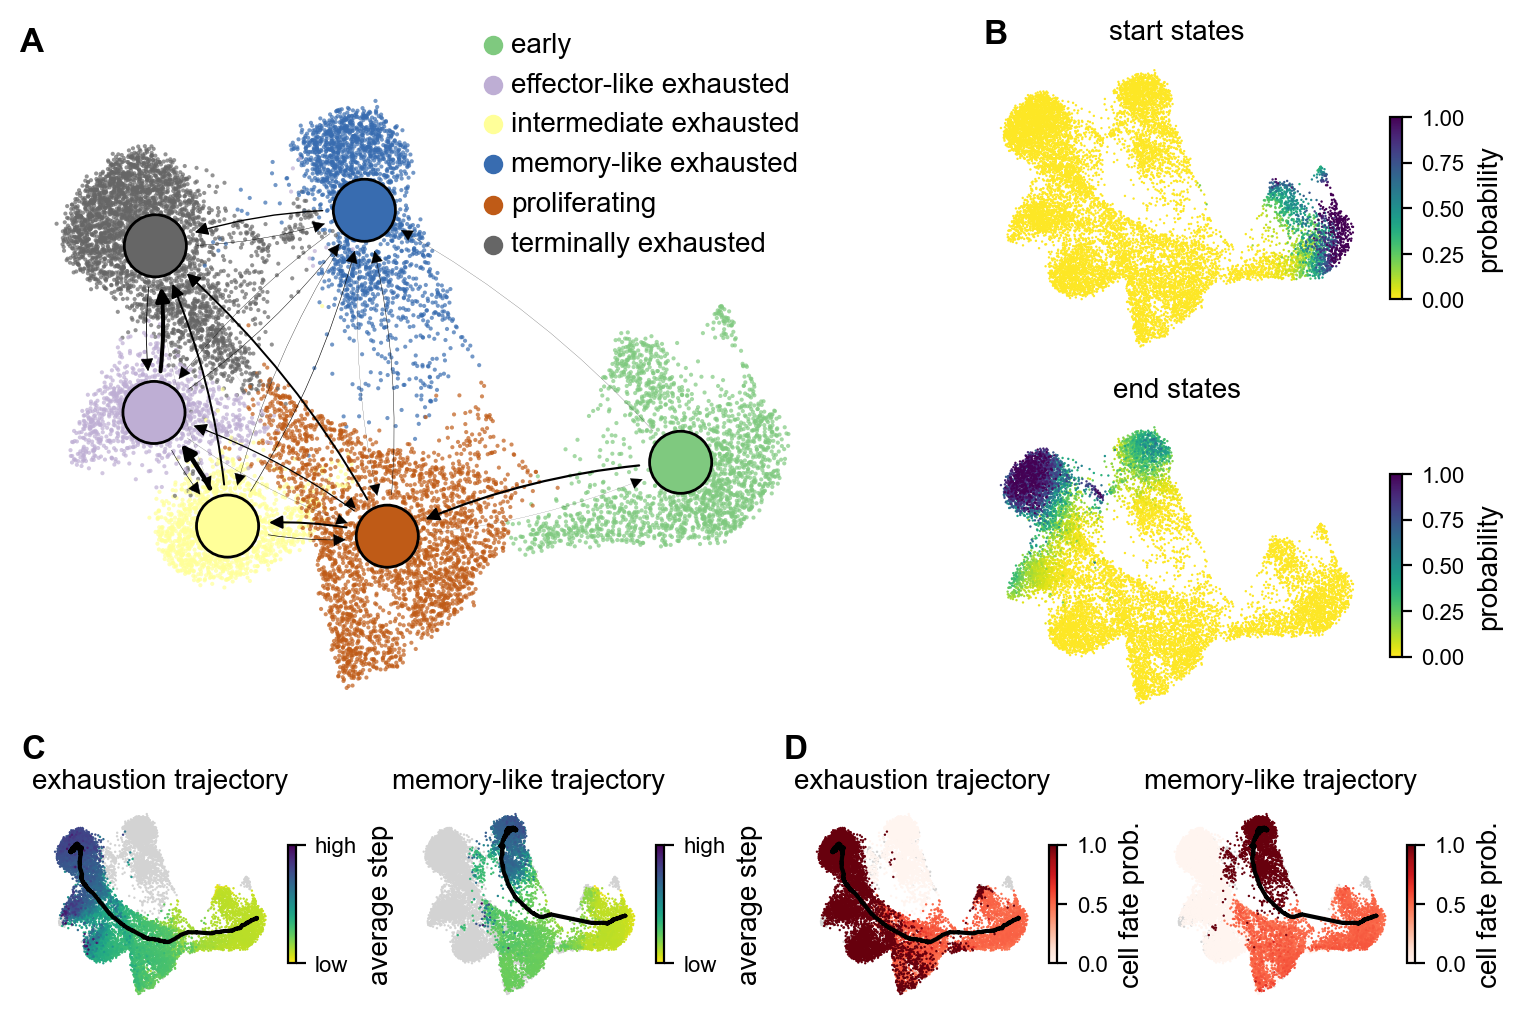

In [12]:
# Figure 4
fig, axs = make_grid((fig_width, fig_width/3*2),
                     {"nrows": 2, "ncols": 1, "row_heights": [5, 2], "col_widths": [1],
                      "sub_grids": [
                          {"nrows": 1, "ncols": 2, "row_heights": [1], "col_widths": [1.5, 1],
                           "sub_grids": [
                               None,
                               {"nrows": 2, "ncols": 1, "row_heights": [1, 1], "col_widths": [1]}
                           ], "wspace": .4},
                          {"nrows": 1, "ncols": 4, "row_heights": [1], "col_widths": [1, 1, 1, 1],
                           "wspace": .05, "hspace": .05}
                      ], "hspace": .4})

# cluster transition graph
sc.pl.umap(adata, color="annotation", ax=axs[0], show=False, title="", alpha=.7)
nx.draw_networkx_nodes(cluster_graph, pos, nodelist=adata.obs.annotation.cat.categories,
                       node_size=500, node_color=adata.uns["annotation_colors"],
                       edgecolors="k", ax=axs[0])
nx.draw_networkx_edges(cluster_graph, pos, edgelist=widths.keys(), node_size=500,
                       width=np.asarray(list(widths.values())) * 20,
                       connectionstyle="arc3,rad=0.1", min_source_margin=15,
                       min_target_margin=15, ax=axs[0])
axs[0].legend(loc="upper right", bbox_to_anchor=(1.0, 1.1))

# velocity terminal states
sc.pl.umap(adata, color="root_cells", cmap="viridis_r", ax=axs[1], show=False,
           colorbar_loc=None, title="start states", s=3)
plt.colorbar(axs[1].get_children()[0], ax=axs[1], shrink=.6, aspect=15, label="probability")

sc.pl.umap(adata, color="end_points", cmap="viridis_r", ax=axs[2], show=False,
           colorbar_loc=None, title="end states", s=3)
plt.colorbar(axs[2].get_children()[0], ax=axs[2], shrink=.6, aspect=15, label="probability")

# Cytopath plots
sc.pl.umap(adata, color="average_step_exh", cmap="viridis_r", ax=axs[3], show=False,
           title="exhaustion trajectory", colorbar_loc=None, s=3)
cbar = plt.colorbar(axs[3].get_children()[0], ax=axs[3], shrink=.6, aspect=15, label="average step",
                    ticks=[adata.obs.average_step_exh.min(), adata.obs.average_step_exh.max()])
cbar.ax.set_yticklabels(["low", "high"])
axs[3].plot(coords_exh[:, 0], coords_exh[:, 1], color="k")

sc.pl.umap(adata, color="average_step_mem", cmap="viridis_r", ax=axs[4], show=False,
           title="memory-like trajectory", colorbar_loc=None, s=3)
cbar = plt.colorbar(axs[4].get_children()[0], ax=axs[4], shrink=.6, aspect=15, label="average step",
                    ticks=[adata.obs.average_step_mem.min(), adata.obs.average_step_mem.max()])
cbar.ax.set_yticklabels(["low", "high"])
axs[4].plot(coords_mem[:, 0], coords_mem[:, 1], color="k")

sc.pl.umap(adata, color="fate_prob_exh", cmap="Reds", ax=axs[5], show=False,
           title="exhaustion trajectory", colorbar_loc=None, s=3)
plt.colorbar(axs[5].get_children()[0], ax=axs[5], shrink=.6, aspect=15, label="cell fate prob.")
axs[5].plot(coords_exh[:, 0], coords_exh[:, 1], color="k")

sc.pl.umap(adata, color="fate_prob_mem", cmap="Reds", ax=axs[6], show=False,
           title="memory-like trajectory", colorbar_loc=None, s=3)
plt.colorbar(axs[6].get_children()[0], ax=axs[6], shrink=.6, aspect=15, label="cell fate prob.")
axs[6].plot(coords_mem[:, 0], coords_mem[:, 1], color="k")

for i, lab in enumerate("AB"):
    axs[i].text(0, 1.02, lab, transform=axs[i].transAxes, **axlab_kws)
    
for i, lab in zip([3, 5], ["C", "D"]):
    axs[i].text(-0.1, 1.2, lab, transform=axs[i].transAxes, **axlab_kws)

fig.savefig(os.path.join(FIGURE_PATH, "fig_04.png"));

In [13]:
# Statistics for root cell and endpoint probabilities
display(adata.obs[["annotation", "root_cells", "end_points"]].groupby("annotation").mean())
display(adata.obs[["annotation", "root_cells", "end_points"]].groupby("annotation").max())

display(adata.obs[["leiden", "root_cells", "end_points"]].groupby("leiden").mean())
display(adata.obs[["leiden", "root_cells", "end_points"]].groupby("leiden").max())

root_cells  end_points
annotation                                     
early                      0.406270    0.000001
effector-like exhausted    0.000000    0.074121
intermediate exhausted     0.000000    0.000846
memory-like exhausted      0.000222    0.152615
proliferating              0.000177    0.000465
terminally exhausted       0.000000    0.560822

root_cells  end_points
annotation                                     
early                      1.000000    0.000342
effector-like exhausted    0.000000    0.670412
intermediate exhausted     0.000000    0.045057
memory-like exhausted      0.192544    0.629413
proliferating              0.224286    0.163658
terminally exhausted       0.000000    1.000000

root_cells    end_points
leiden                          
0         0.000000  7.425432e-01
1         0.000315  2.338523e-06
2         0.000000  8.457487e-04
3         0.000000  2.250721e-01
4         0.000000  7.412052e-02
5         0.524910  5.792009e-07
6         0.000000  1.056039e-03
7         0.000000  1.102718e-01
8         0.000662  9.274560e-03
9         0.390964  1.324871e-06
10        0.009556  1.270606e-06
11        0.000000  2.935628e-01
12        0.568390  7.462111e-06

root_cells  end_points
leiden                        
0         0.000000    1.000000
1         0.224286    0.000386
2         0.000000    0.045057
3         0.000000    0.629413
4         0.000000    0.670412
5         1.000000    0.000003
6         0.000000    0.163658
7         0.000000    0.590288
8         0.192544    0.196875
9         1.000000    0.000003
10        0.207877    0.000004
11        0.000000    1.000000
12        1.000000    0.000342

In [14]:
# Load AnnData with convergent trajectories
adata_c2p = sc.read_h5ad(os.path.join(DATA_PATH, "tex_data_chronic_cytopath_hierarchical.h5ad"))

In [15]:
# Randomly sample 100 of the 1000 simulations
rng = np.random.default_rng(42)
sampled_seqs = rng.choice(adata_c2p.uns["samples"]["cell_sequences"], size=100, replace=False, axis=0)

In [16]:
# Create cell level trajectory data and change trajectory identifier
c2p_data = pd.DataFrame(adata_c2p.uns["trajectories"]["cells_along_trajectories"])
c2p_data["Trajectory"] = c2p_data["End point"].map({"0": "exhaustion", "3": "memory-like"})
c2p_data["Cluster"] = adata.obs["annotation"][c2p_data["Cell"].values].values

# Add marker expression data
markers = ["Tcf7", "Slamf6", "Xcl1", "Ccr6", "Tnfsf8",
           "Ccl5", "Cd7", "Cxcr6", "Nkg7",
           "Pdcd1", "Tox"]

c2p_data_ = c2p_data.copy()

for marker in markers:
    c2p_data_[marker] = adata_c2p[c2p_data_["Cell"].values, marker].layers["log1p"].todense()
c2p_data_ = c2p_data_.melt(id_vars=["Trajectory", "Step", "Cluster"], value_vars=markers,
                           var_name="marker", value_name="norm_expression")
c2p_data_['pseudotime deciles'] = c2p_data_.groupby("Trajectory")["Step"]\
    .transform(lambda x: pd.qcut(x, 10, labels=False))

# Calculate majority clusters for each decile
majority_clusters = c2p_data_.groupby(["pseudotime deciles",
                                       "Trajectory"])["Cluster"]\
    .agg(lambda x: x.mode().iloc[0]).reset_index()

# Create a color mapping for the majority clusters
cluster_colors = dict(zip(adata.obs.annotation.cat.categories, adata.uns["annotation_colors"]))

Computing coordinates:   0%|          | 0/2 [00:00<?, ? lineage/s]

INFO:root:Using precomputed state probability sampling
INFO:root:Using precomputed Markov chains
INFO:root:Clustering the samples.
INFO:be.kuleuven.dtai.distance:Computing n-dim distances
INFO:be.kuleuven.dtai.distance:Compute distances in C (parallel=OMP)


Computing coordinates:   0%|          | 0/6 [00:00<?, ? lineage/s]

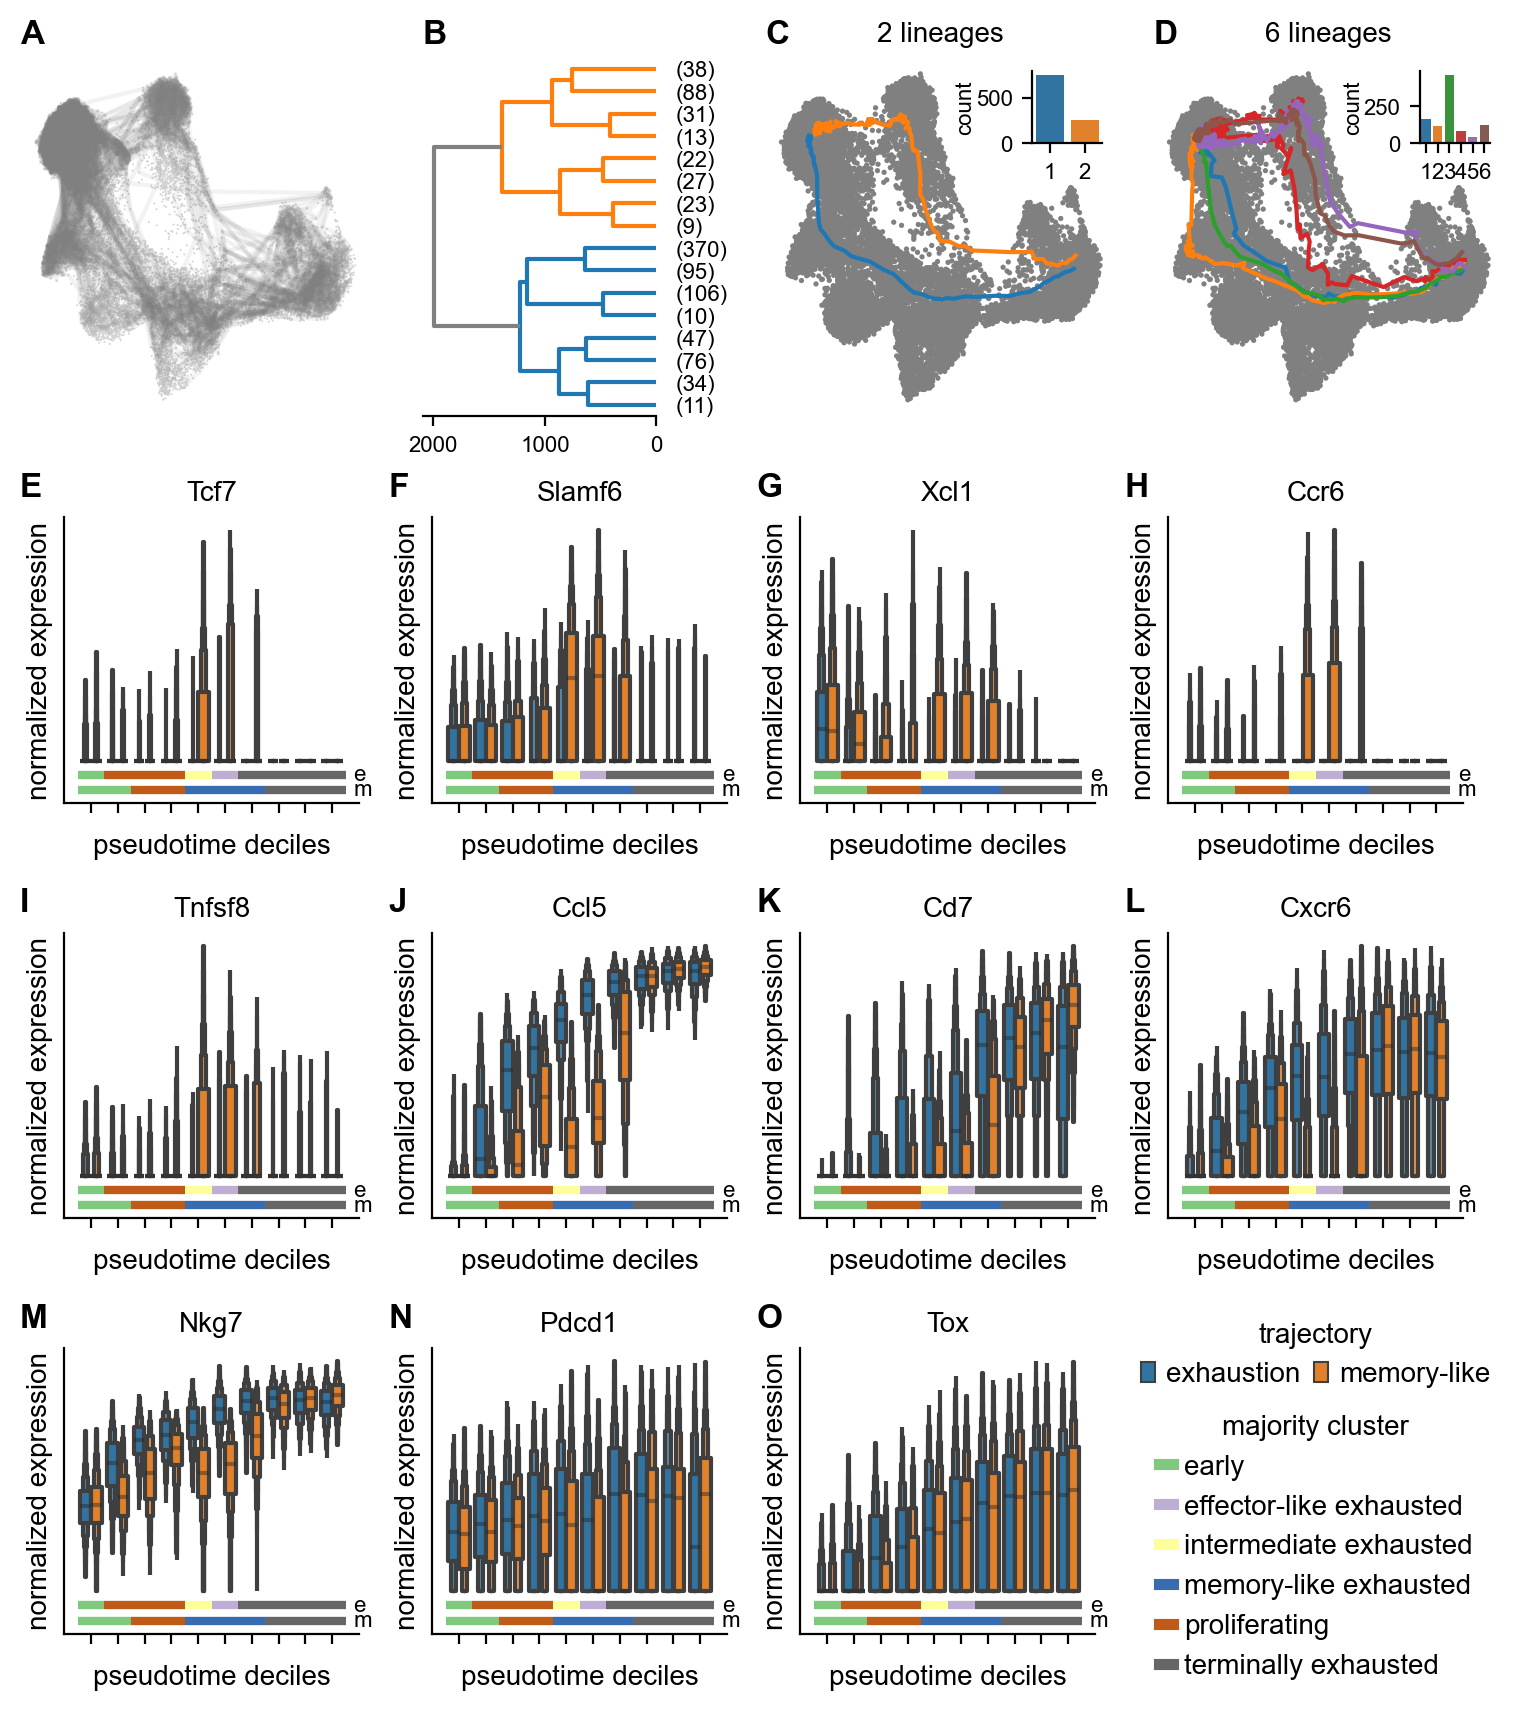

In [17]:
# Figure 5
fig, axs = make_grid((fig_width, fig_width/8*9),
                     {"nrows": 2, "ncols": 1, "row_heights": [1.1, 3], "col_widths": [1],
                      "sub_grids": [
                          {"nrows": 1, "ncols": 4, "row_heights": [1], "col_widths": [1.5, 1, 1.5, 1.5],
                           "wspace": .1, "hspace": .1},
                          {"nrows": 3, "ncols": 4, "row_heights": [1, 1, 1], "col_widths": [1, 1, 1, 1],
                           "hspace": 0.05}
                      ]}
                     )

# Plot cell sequences
sc.pl.umap(adata_c2p, show=False, ax=axs[0], s=2)
for seq in sampled_seqs:
    coords = adata_c2p.obsm["X_umap"][seq]
    axs[0].plot(coords[:, 0], coords[:, 1], alpha=.1, color="grey")

# Plot dendrogram at default level 3
hierarchy.set_link_color_palette(["C0", "C1", "grey"])
dendro = hierarchy.dendrogram(adata_c2p.uns["cytopath"]["lineage_inference_linkage"], p=3,
                              truncate_mode="level", orientation="left", ax=axs[1],
                              above_threshold_color="grey", leaf_font_size=8)
sns.despine(ax=axs[1], left=True)


# Plot two lineages
c2p.plot_cytopath_lineages(adata_c2p, basis="umap", ax=axs[2])
axs[2].set_title("2 lineages")
inset_ax = inset_axes(axs[2], width="20%", height="20%", loc=1)
sns.countplot(x=np.sort(adata_c2p.uns["cytopath"]["lineage_inference_clusters"]).astype(str), ax=inset_ax)
inset_ax.set_ylabel("count", fontsize=8, labelpad=.1)

# Plot six lineages
adata_ = c2p.cytopath.infer_cytopath_lineages(adata_c2p, recalc_items=False,
                                              basis="pca", num_lineages=6,
                                              method="linkage", distance_func="dtw",
                                              differencing=False, copy=True)
c2p.plot_cytopath_lineages(adata_, basis="umap", ax=axs[3])
axs[3].set_title("6 lineages")
inset_ax = inset_axes(axs[3], width="20%", height="20%", loc=1)
sns.countplot(x=np.sort(adata_.uns["cytopath"]["lineage_inference_clusters"]).astype(str), ax=inset_ax)
inset_ax.set_ylabel("count", fontsize=8, labelpad=.1)

# Marker expression boxplots along convergent trajectories
for i, ax in enumerate(axs[4:-1]):
    sns.boxenplot(c2p_data_[c2p_data_.marker==markers[i]], x="pseudotime deciles", y="norm_expression",
                  hue="Trajectory", palette="tab10", showfliers=False, ax=ax)
    ax.set(yticks=[], ylabel="normalized expression", xticklabels=[])
    ax.set_title(markers[i])
    
    # Add colored lines below the boxes for majority clusters
    y_min, y_max = ax.get_ylim()
    for pos, decile in enumerate(sorted(majority_clusters["pseudotime deciles"].unique())):        
        color = cluster_colors[majority_clusters.loc[(majority_clusters["pseudotime deciles"] == decile) &
                                                     (majority_clusters["Trajectory"] == "exhaustion"),
                                                     "Cluster"].item()]
        ax.hlines(y=(y_min - .01*(y_max-y_min)), xmin=(pos - 0.5), xmax=(pos + 0.5),
                   color=color, linestyle='-', linewidth=3)
    
        color = cluster_colors[majority_clusters.loc[(majority_clusters["pseudotime deciles"] == decile) &
                                                     (majority_clusters["Trajectory"] == "memory-like"),
                                                     "Cluster"].item()]
        ax.hlines(y=(y_min - .07*(y_max-y_min)), xmin=(pos - 0.5), xmax=(pos + 0.5),
                   color=color, linestyle='-', linewidth=3)

    ax.text(pos + .8, (y_min - .01*(y_max-y_min)), "e", ha="left", va="center", fontsize=8)
    ax.text(pos + .8, (y_min - .07*(y_max-y_min)), "m", ha="left", va="center", fontsize=8)
    ax.get_legend().remove()


# Create a legend for the trajectory
legend = axs[-2].legend()
handles, labels = axs[-2].get_legend_handles_labels()
legend.remove()

# Add a legend for the cluster annotations
legend_elements = [plt.Line2D([0], [0], color=c, label=l, linewidth=4) for l, c in cluster_colors.items()]
legend = axs[-1].legend(handles=legend_elements, frameon=False, loc="lower center",
                        bbox_to_anchor=(0.5, -0.25), title="majority cluster")
axs[-1].legend(handles=handles, labels=labels, loc="upper center",
               bbox_to_anchor=(0.5, 1.18), title="trajectory", ncol=2,
               columnspacing=0.5)
axs[-1].add_artist(legend)
axs[-1].axis("off")

for i, lab in enumerate(string.ascii_uppercase[:4]):
    axs[i].text(0, 1.02, lab, transform=axs[i].transAxes, **axlab_kws)
for i, lab in enumerate(string.ascii_uppercase[4:15]):
    axs[i+4].text(-.15, 1.05, lab, transform=axs[i+4].transAxes, **axlab_kws)
    
# fig.savefig(os.path.join(FIGURE_PATH, "fig_05.png"));

In [18]:
# Figure 6
fig, axs = make_grid((fig_width, fig_width/12*7),
                     {"nrows": 2, "ncols": 1, "row_heights": [1, 1.1], "col_widths": [1], "hspace": 0.1,
                      "sub_grids": [
                          {"nrows": 1, "ncols": 2, "row_heights": [1], "col_widths": [2, 1],
                           "wspace": 0},
                          {"nrows": 1, "ncols": 3, "row_heights": [1], "col_widths": [1, 1, 1],
                           "wspace": 0}
                      ]})
for ax in axs:
    ax.axis("off")

for i, label in enumerate(string.ascii_uppercase[:3]):
    axs[i].text(0, 1.0, label, transform=axs[i].transAxes, **axlab_kws)


skunk.connect(axs[0], "plan")
skunk.connect(axs[1], "sort")
skunk.connect(axs[2], "exh")
skunk.connect(axs[3], "mem")
skunk.connect(axs[4], "pre")
svg = skunk.insert({"plan": os.path.join(FIGURE_PATH, "transfer_plan.svg"),
                    "sort": os.path.join(FIGURE_PATH, "transfer_sort.svg"),
                    "exh": os.path.join(FIGURE_PATH, "transfer_exh.svg"),
                    "mem": os.path.join(FIGURE_PATH, "transfer_mem.svg"),
                    "pre": os.path.join(FIGURE_PATH, "transfer_pre.svg")})
skunk.display(svg)

with open(os.path.join(FIGURE_PATH, "fig_06.svg"), "w") as f:
    f.write(svg)
plt.close()

## Supplementary figures

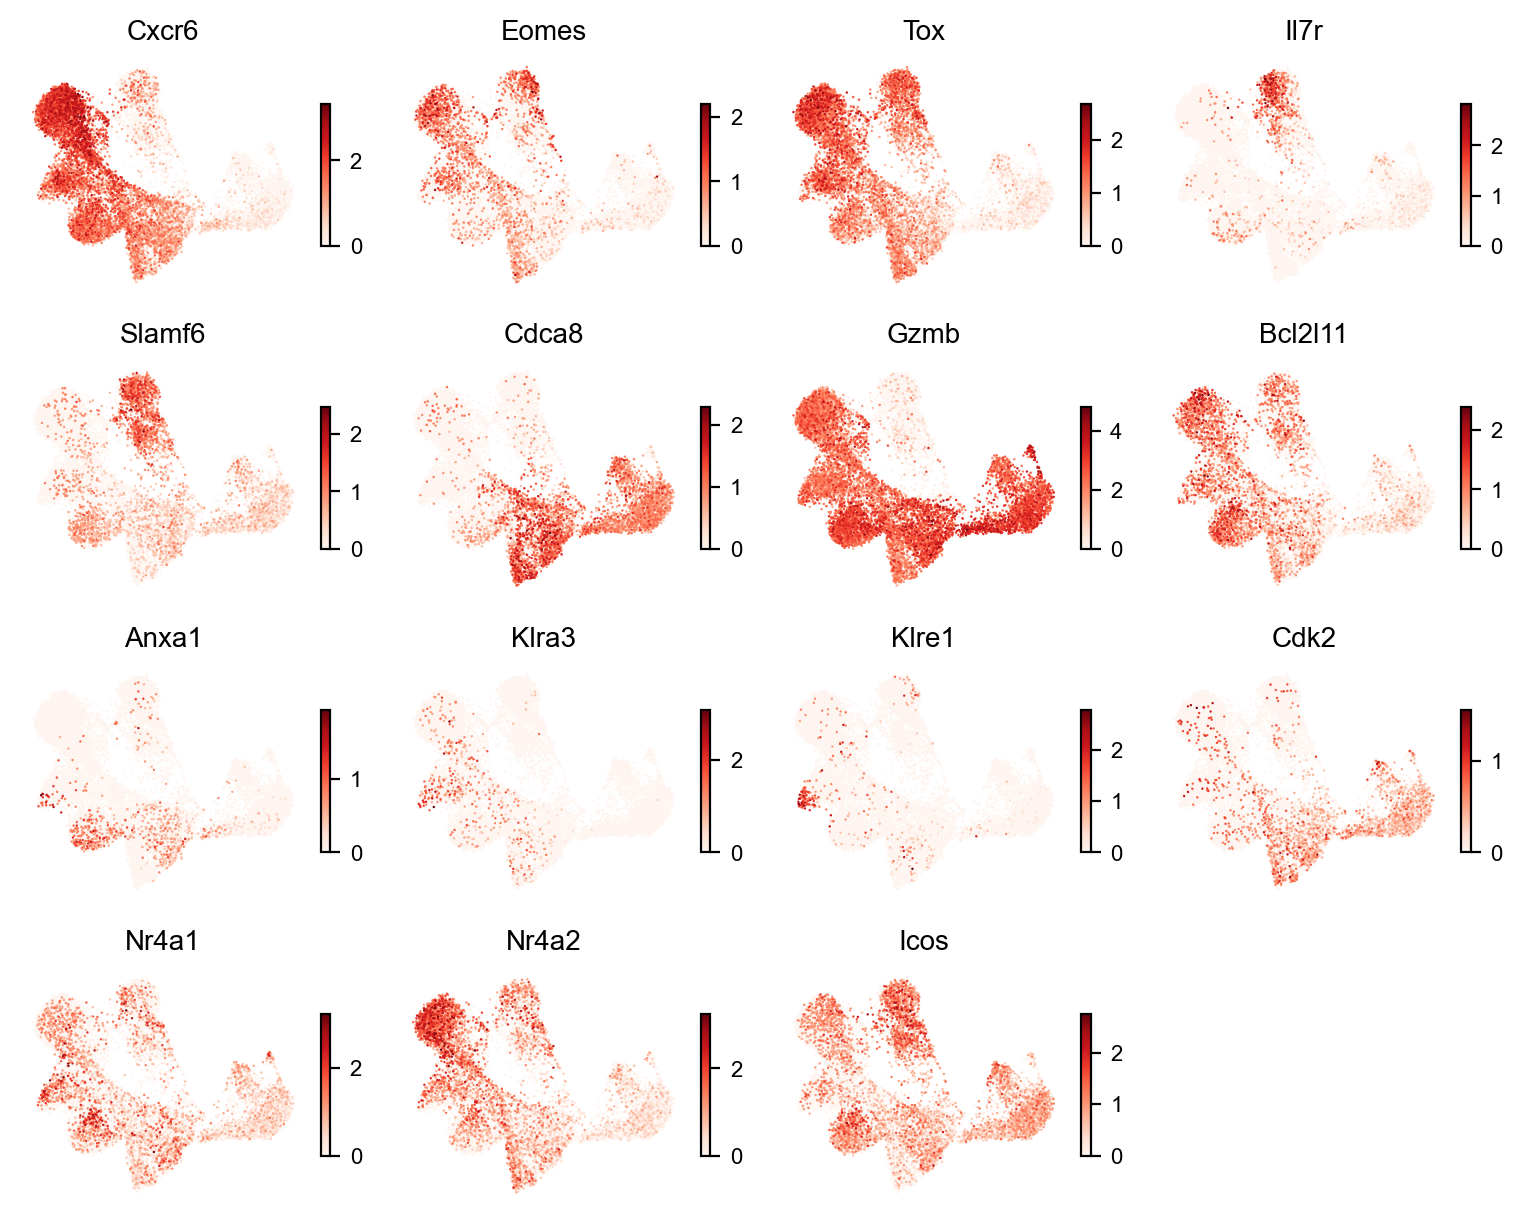

In [19]:
# Figure S1
relevant_genes = ["Cxcr6", "Eomes", "Tox", "Il7r", "Slamf6", "Cdca8",
                  "Gzmb", "Bcl2l11", "Anxa1", "Klra3", "Klre1", "Cdk2",
                  "Nr4a1", "Nr4a2", "Icos"]

fig, axs = make_grid((fig_width, fig_width/5*4),
                     {"nrows": 4, "ncols": 4, "row_heights": [1, 1, 1, 1], "col_widths": [1, 1, 1, 1],
                      "hspace": 0.1, "wspace": 0.1})

for i, gene in enumerate(relevant_genes):
    sc.pl.umap(adata, color=gene, ax=axs[i], cmap=cmap_exp, layer="log1p",
               frameon=False, show=False, colorbar_loc=None, s=3)
    plt.colorbar(axs[i].get_children()[0], ax=axs[i], shrink=.6, aspect=15)
axs[-1].set_visible(False)

fig.savefig(os.path.join(FIGURE_PATH, "fig_s01.png"))

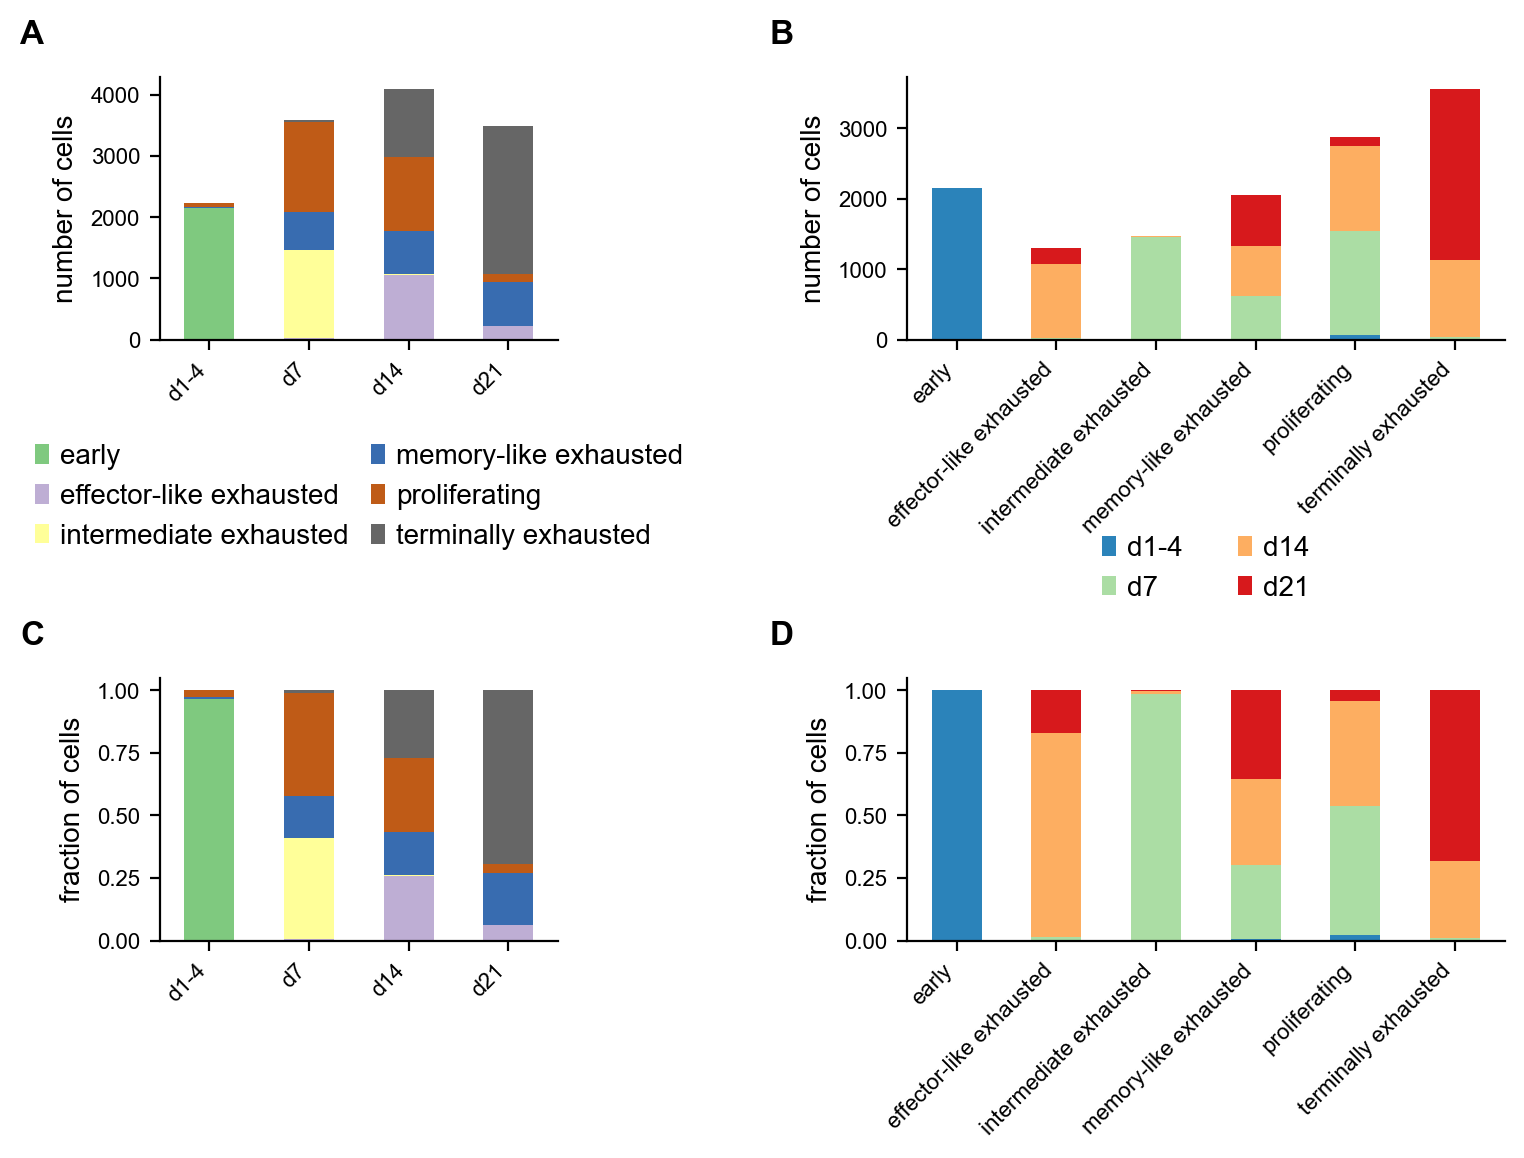

In [20]:
# Figure S2
fig, axs = make_grid((fig_width, fig_width/4*3),
                     {"nrows": 2, "ncols": 2, "row_heights": [1, 1], "col_widths": [2, 3],
                      "hspace": 0.15, "wspace": 0.1})

df = adata.obs.groupby(["timepoint", "annotation"]).size().unstack()
df.plot.bar(stacked=True, rot=45, ax=axs[0], color=adata.uns["annotation_colors"], legend=False)

df = df.div(df.sum(axis=1), axis=0)
df.plot.bar(stacked=True, rot=45, ax=axs[2], color=adata.uns["annotation_colors"], legend=False)

axs[0].set_ylabel("number of cells")
axs[0].legend(loc="upper center", bbox_to_anchor=(0.5, -.3), ncol=2,
              columnspacing=0.8)

axs[2].set_ylabel("fraction of cells")

df = adata.obs.groupby(["annotation", "timepoint"]).size().unstack()
df.plot.bar(stacked=True, rot=45, ax=axs[1], color=adata.uns["timepoint_colors"], legend=False)

df = df.div(df.sum(axis=1), axis=0)
df.plot.bar(stacked=True, rot=45, ax=axs[3], color=adata.uns["timepoint_colors"], legend=False)

axs[1].set_ylabel("number of cells")
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -.65), ncol=2)

axs[3].set_ylabel("fraction of cells")


for ax in axs:
    ax.set_xticklabels(labels=ax.get_xticklabels(), ha="right")
    ax.set_xlabel("")
    
for i, lab in zip([0, 2], ["A", "C"]):
    axs[i].text(-.35, 1.1, lab, transform=axs[i].transAxes, **axlab_kws)
for i, lab in zip([1, 3], ["B", "D"]):
    axs[i].text(-.23, 1.1, lab, transform=axs[i].transAxes, **axlab_kws)

fig.savefig(os.path.join(FIGURE_PATH, "fig_s02.png"))

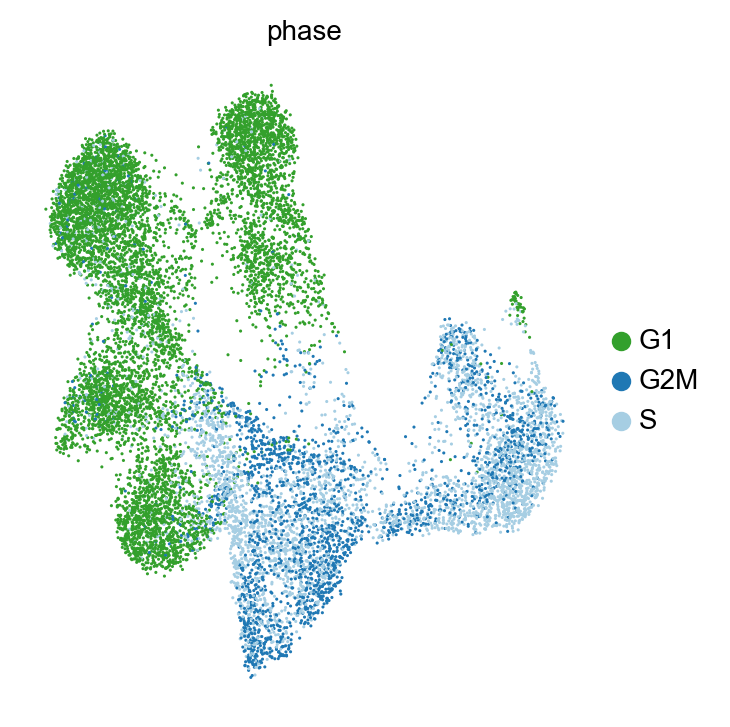

In [21]:
# Fig S3
adata.uns["phase_colors"] = np.asarray(["#33a02c", "#1f78b4", "#a6cee3"])
fig, ax = plt.subplots(figsize=(fig_width/2, fig_width/2))
sc.pl.umap(adata, color="phase", ax=ax, show=False, s=5)
fig.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, "fig_s03.png"))

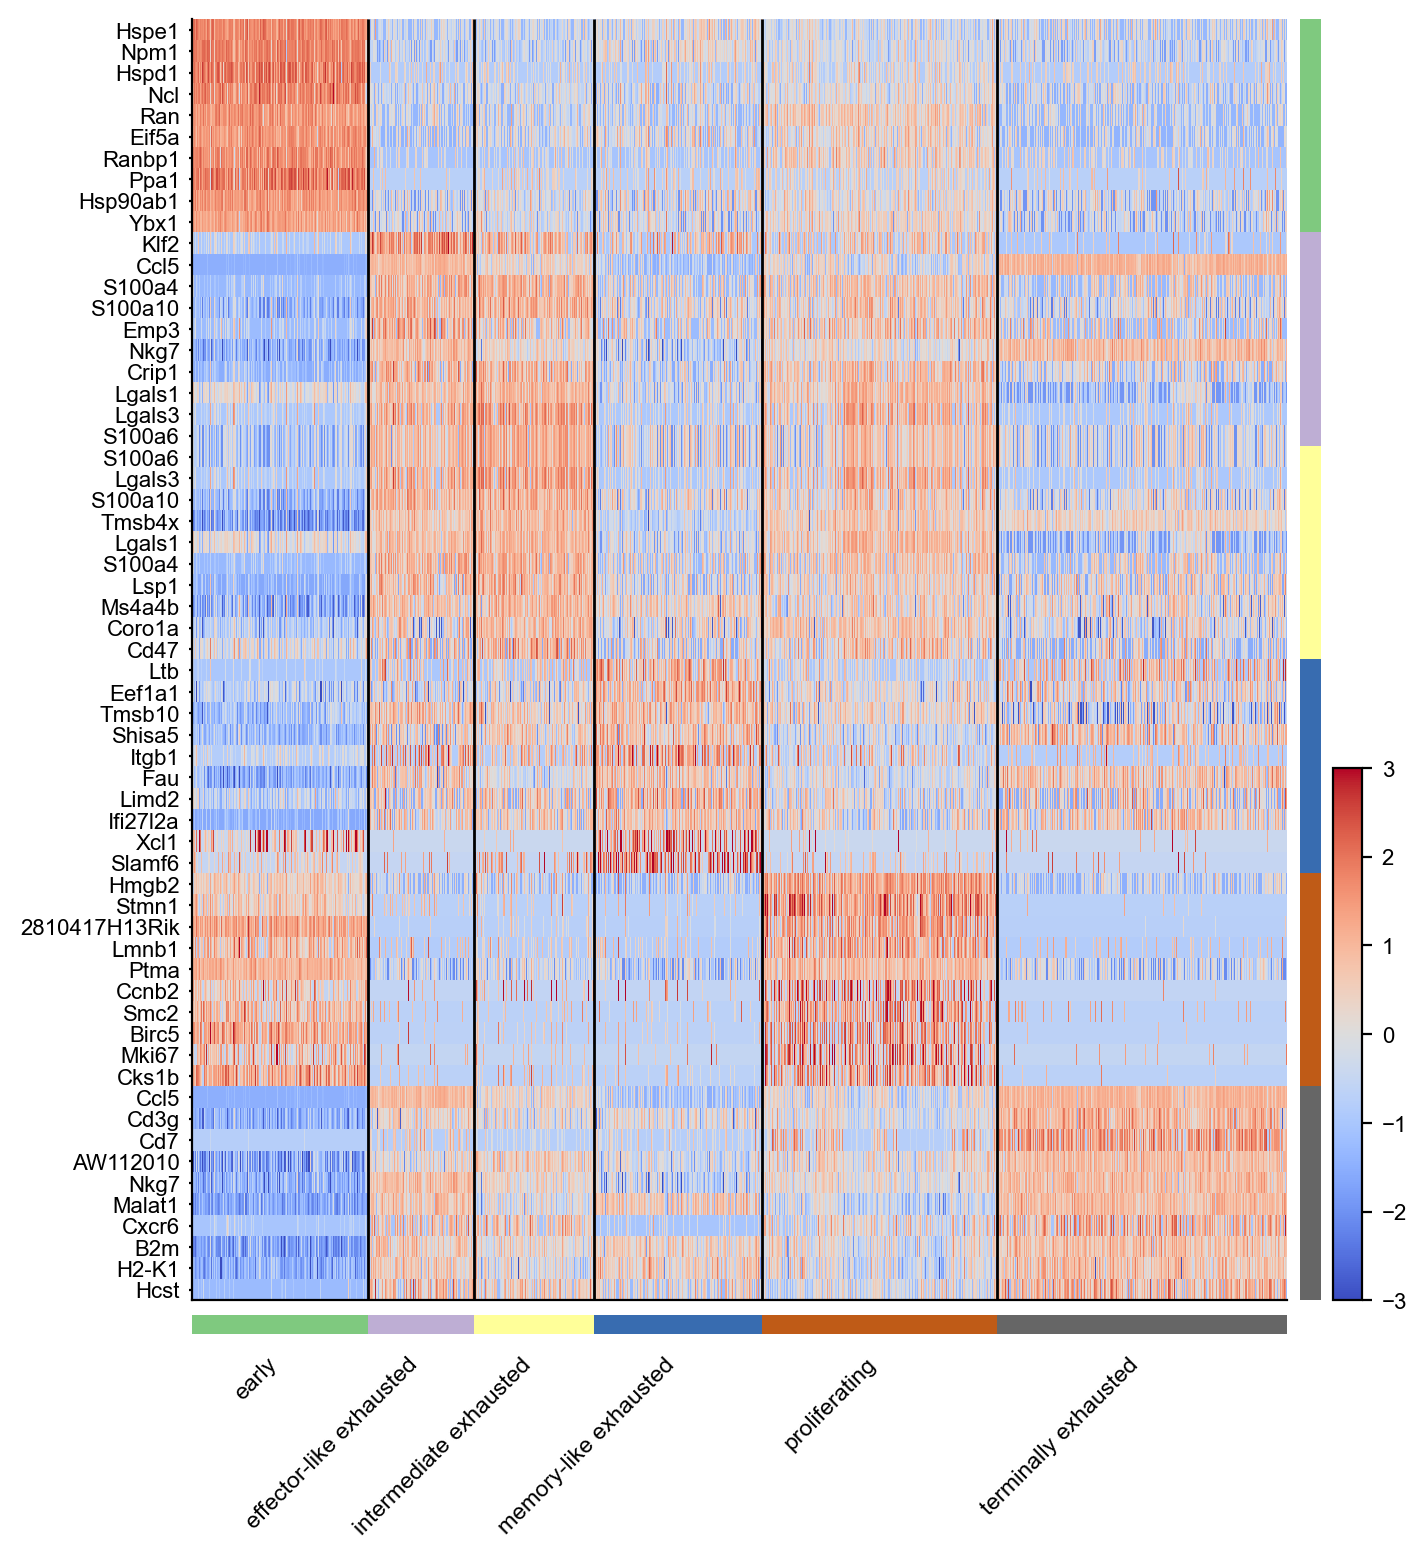

In [22]:
# Figure S4
fig = sc.pl.rank_genes_groups_heatmap(adata, key="rank_genes_groups_annot", n_genes=10,
                                      layer="scaled", swap_axes=True, cmap="coolwarm",
                                      vmin=-3, vcenter=0, vmax=3, show_gene_labels=True,
                                      dendrogram=False, show=False,
                                      figsize=(fig_width, fig_width/6*7))
fig["groupby_ax"].set_xlabel("")
fig["groupby_ax"].set_xticklabels(adata.obs.annotation.cat.categories, rotation=45, ha="right")
fig["heatmap_ax"].set_yticklabels(fig["heatmap_ax"].get_yticklabels(), fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_PATH, "fig_s04.png"))

In [23]:
# Differential expression analysis for endpoints
term_groups = ["terminally exhausted", "memory-like exhausted"]

sc.tl.rank_genes_groups(adata, groupby="annotation", method="wilcoxon",
                        key_added="rank_genes_groups_endpoints",
                        groups=term_groups)

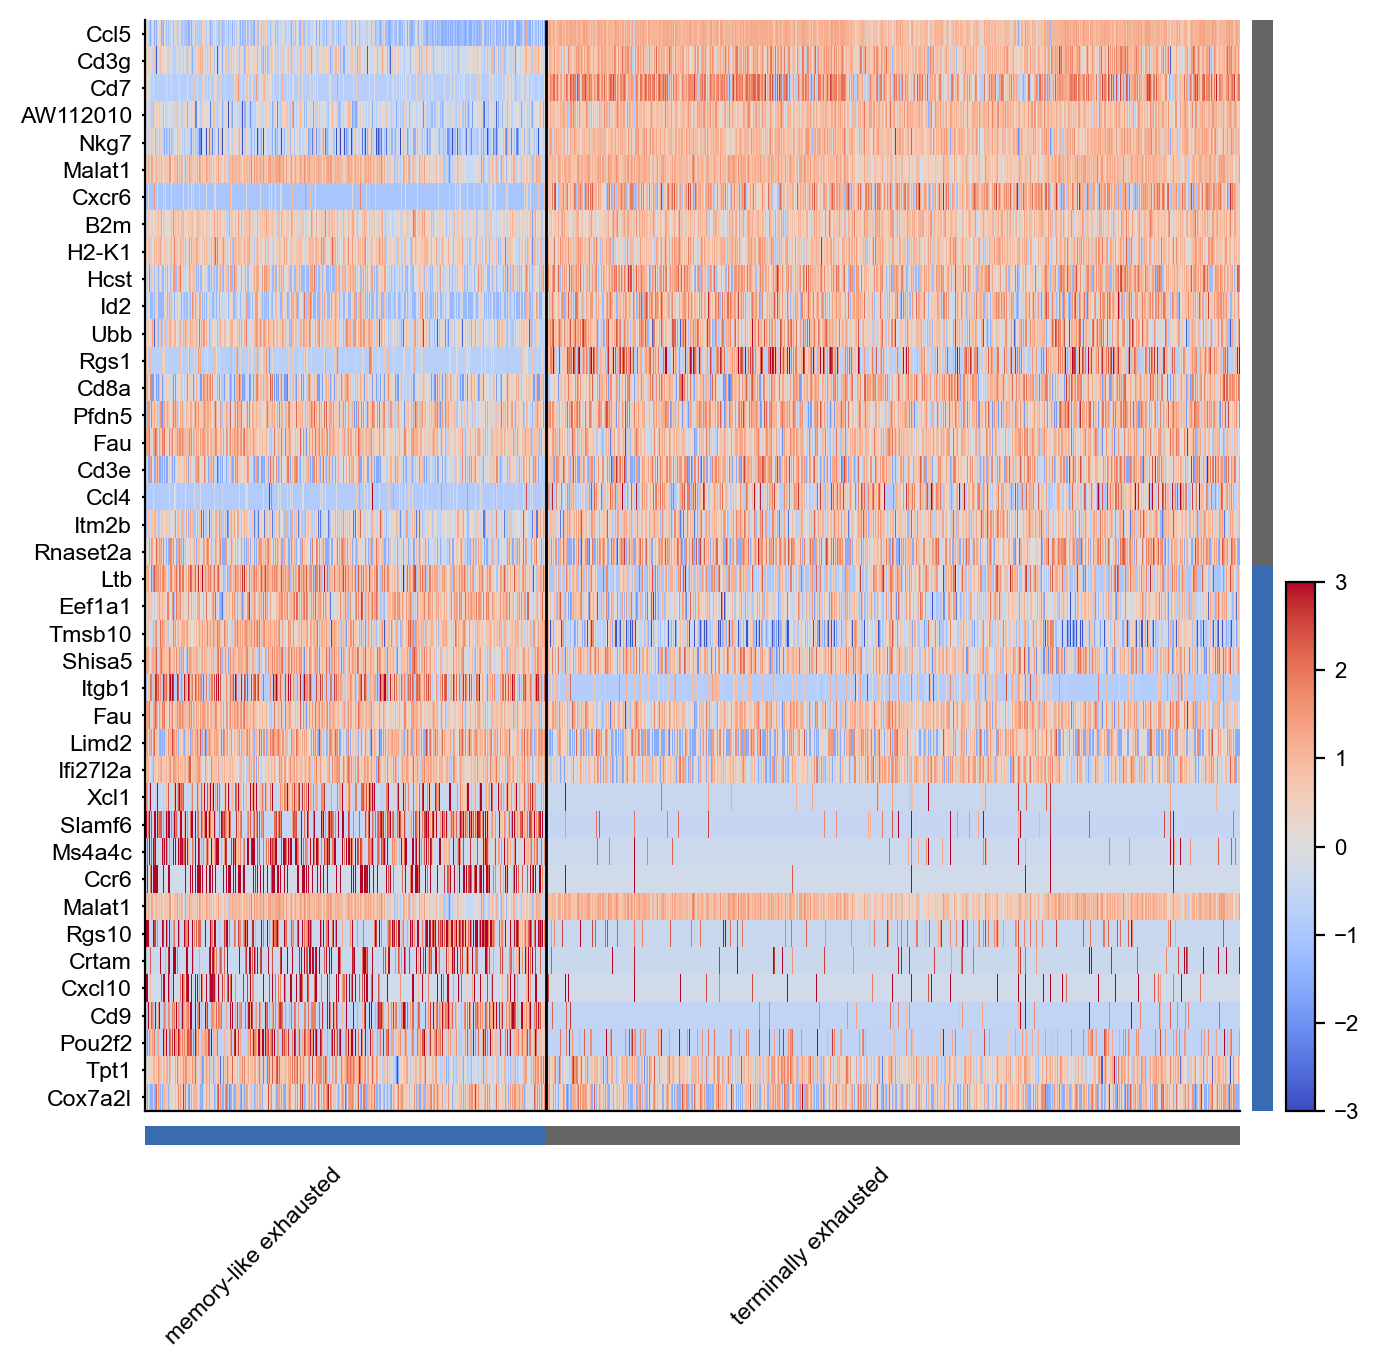

In [24]:
# Fig S5
fig = sc.pl.rank_genes_groups_heatmap(adata[adata.obs["annotation"].isin(term_groups)],
                                      key="rank_genes_groups_endpoints",
                                      groups=term_groups, n_genes=20,
                                      layer="scaled", swap_axes=True, cmap="coolwarm",
                                      vmin=-3, vcenter=0, vmax=3, show_gene_labels=True,
                                      dendrogram=False, show=False,
                                      figsize=(fig_width, fig_width))
fig["groupby_ax"].set_xlabel("")
fig["groupby_ax"].set_xticklabels(fig["groupby_ax"].get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()

plt.savefig(os.path.join(FIGURE_PATH, "fig_s05.png"))

In [25]:
# Create cell level trajectory data and change trajectory identifier
cytopath_data = pd.DataFrame(adata.uns["trajectories"]["cells_along_trajectories"])
cytopath_data["Trajectory"] = cytopath_data["End point"].map({"0": "exhaustion", "3": "memory-like"})
cytopath_data

End point   Trajectory   Cell         Step  Allignment Score
0             0   exhaustion      0   152.752087          0.428196
1             0   exhaustion      1   160.355001          0.160819
2             0   exhaustion      2   154.080199          0.387851
3             0   exhaustion      3   205.337958          0.086844
4             0   exhaustion      4   151.537120          0.267717
...         ...          ...    ...          ...               ...
17124         3  memory-like  13401  1072.168635          0.345279
17125         3  memory-like  13402   979.659376          0.264210
17126         3  memory-like  13404   534.323554          0.093563
17127         3  memory-like  13405  1035.727946          0.353547
17128         3  memory-like  13408   988.459867          0.267895

[17129 rows x 5 columns]

In [26]:
# Add marker expression data
cytopath_data_ = cytopath_data.copy()

for marker in markers:
    cytopath_data_[marker] = adata[cytopath_data_["Cell"].values, marker].layers["log1p"].todense()
cytopath_data_ = cytopath_data_.melt(id_vars=["Trajectory", "Step"], value_vars=markers,
                                     var_name="marker", value_name="norm_expression")
cytopath_data_["pseudotime deciles"] = cytopath_data_.groupby("Trajectory")["Step"]\
    .transform(lambda x: pd.qcut(x, 10, labels=False))

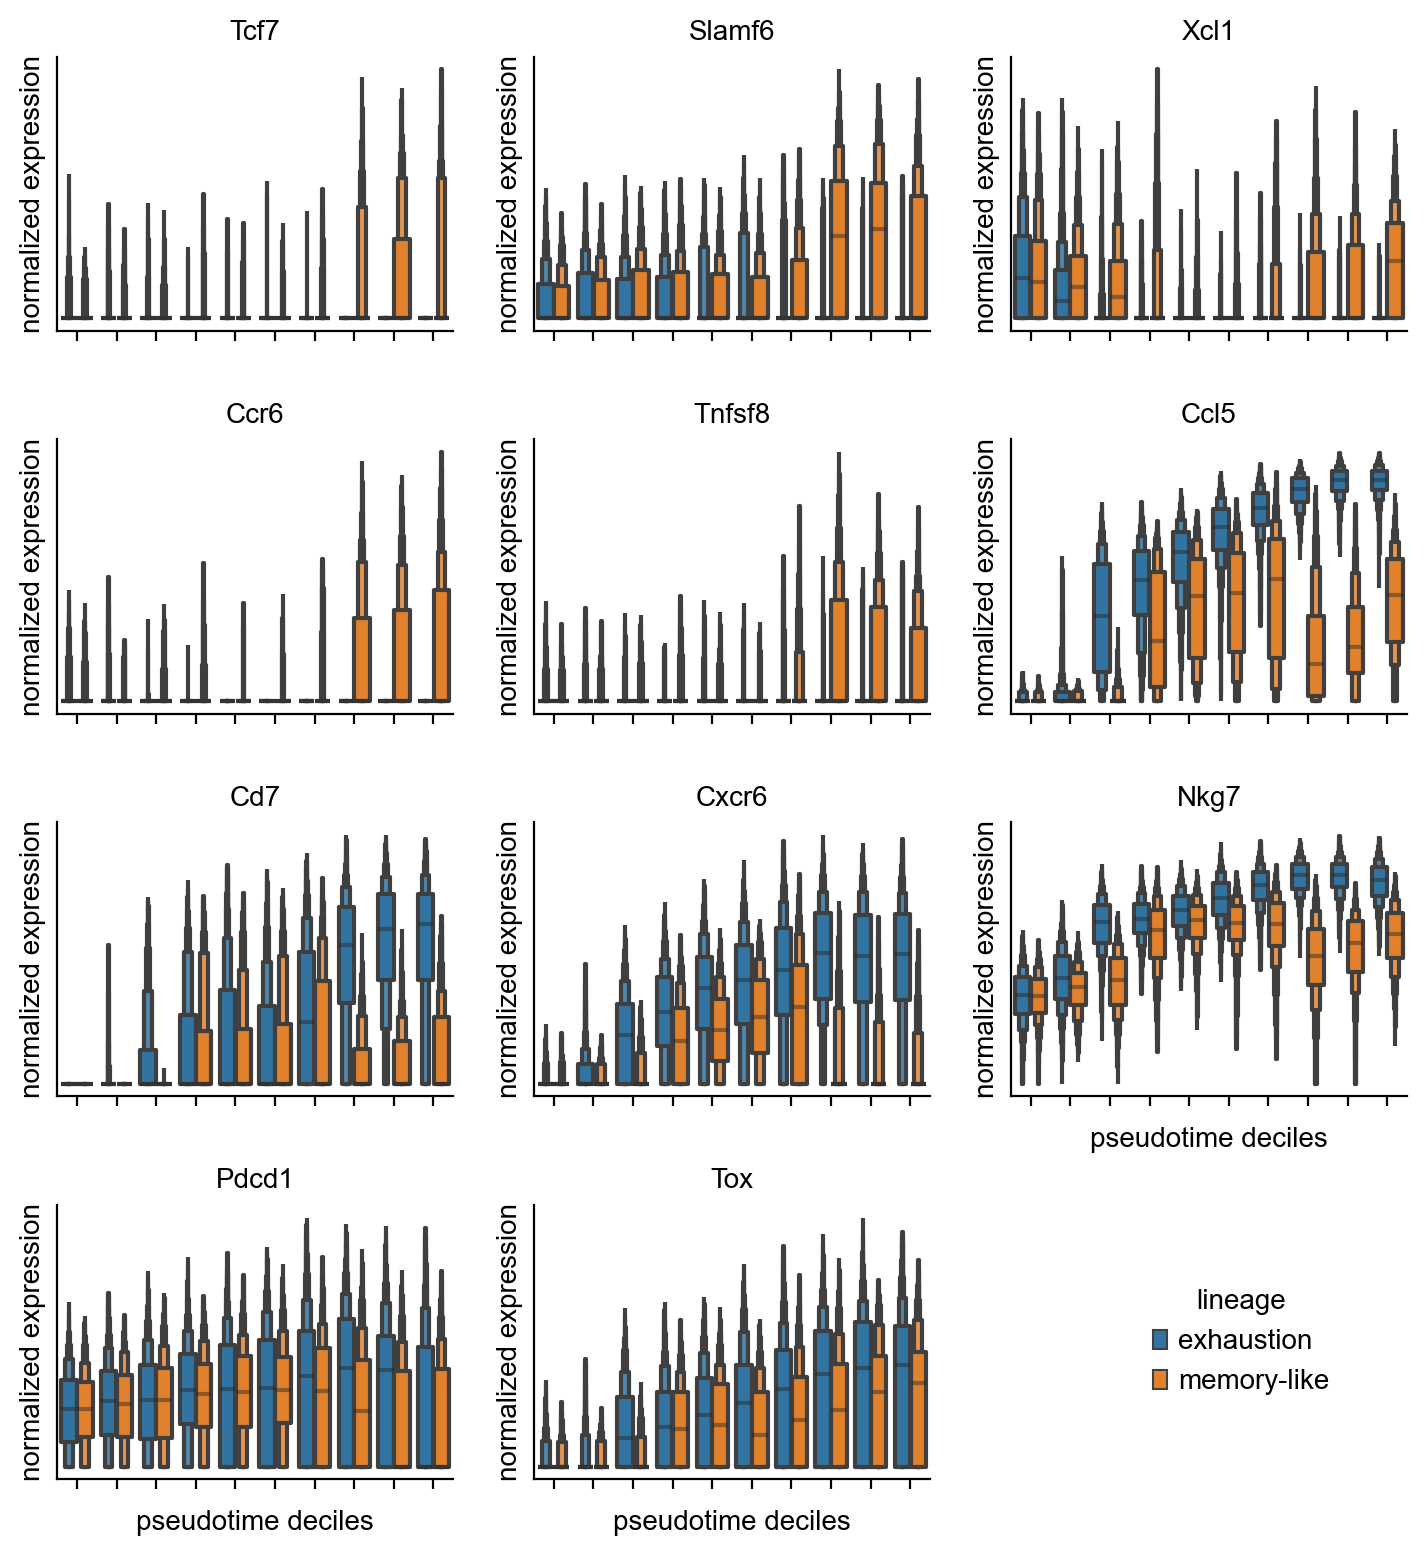

In [27]:
# Fig S6
# Marker expression boxplots along trajectories
p = sns.FacetGrid(cytopath_data_, col="marker", sharey=False, col_wrap=3, height=2, aspect=5/4)
p.map_dataframe(sns.boxenplot, x="pseudotime deciles", y="norm_expression", hue="Trajectory",
                palette="tab10", showfliers=False)
p.set(yticks=[], ylabel="normalized expression")
p.set(xticklabels=[])
p.set_titles(col_template="{col_name}")
p.axes.ravel()[-1].legend(loc="center left", bbox_to_anchor=(1.5, 0.5), title="lineage")
plt.savefig(os.path.join(FIGURE_PATH, "fig_s06.png"))

In [28]:
adata_c2p.obs[["average_step_exh", "average_step_mem"]] = adata_c2p.uns["trajectories"]["step_time"].T
adata_c2p.obs[["fate_prob_exh", "fate_prob_mem"]] = adata_c2p.uns["trajectories"]["cell_fate_probability"].T
coords_exh_c2p = adata_c2p.uns["trajectories"]["trajectories_coordinates"]["0"]["trajectory_0_coordinates"]
coords_mem_c2p = adata_c2p.uns["trajectories"]["trajectories_coordinates"]["3"]["trajectory_0_coordinates"]

INFO:root:Using precomputed state probability sampling
INFO:root:Using precomputed Markov chains
INFO:root:Clustering the samples.
INFO:be.kuleuven.dtai.distance:Computing n-dim distances
INFO:be.kuleuven.dtai.distance:Compute distances in C (parallel=OMP)


Computing coordinates:   0%|          | 0/3 [00:00<?, ? lineage/s]

INFO:root:Using precomputed state probability sampling
INFO:root:Using precomputed Markov chains
INFO:root:Clustering the samples.
INFO:be.kuleuven.dtai.distance:Computing n-dim distances
INFO:be.kuleuven.dtai.distance:Compute distances in C (parallel=OMP)


Computing coordinates:   0%|          | 0/4 [00:00<?, ? lineage/s]

INFO:root:Using precomputed state probability sampling
INFO:root:Using precomputed Markov chains
INFO:root:Clustering the samples.
INFO:be.kuleuven.dtai.distance:Computing n-dim distances
INFO:be.kuleuven.dtai.distance:Compute distances in C (parallel=OMP)


Computing coordinates:   0%|          | 0/5 [00:00<?, ? lineage/s]

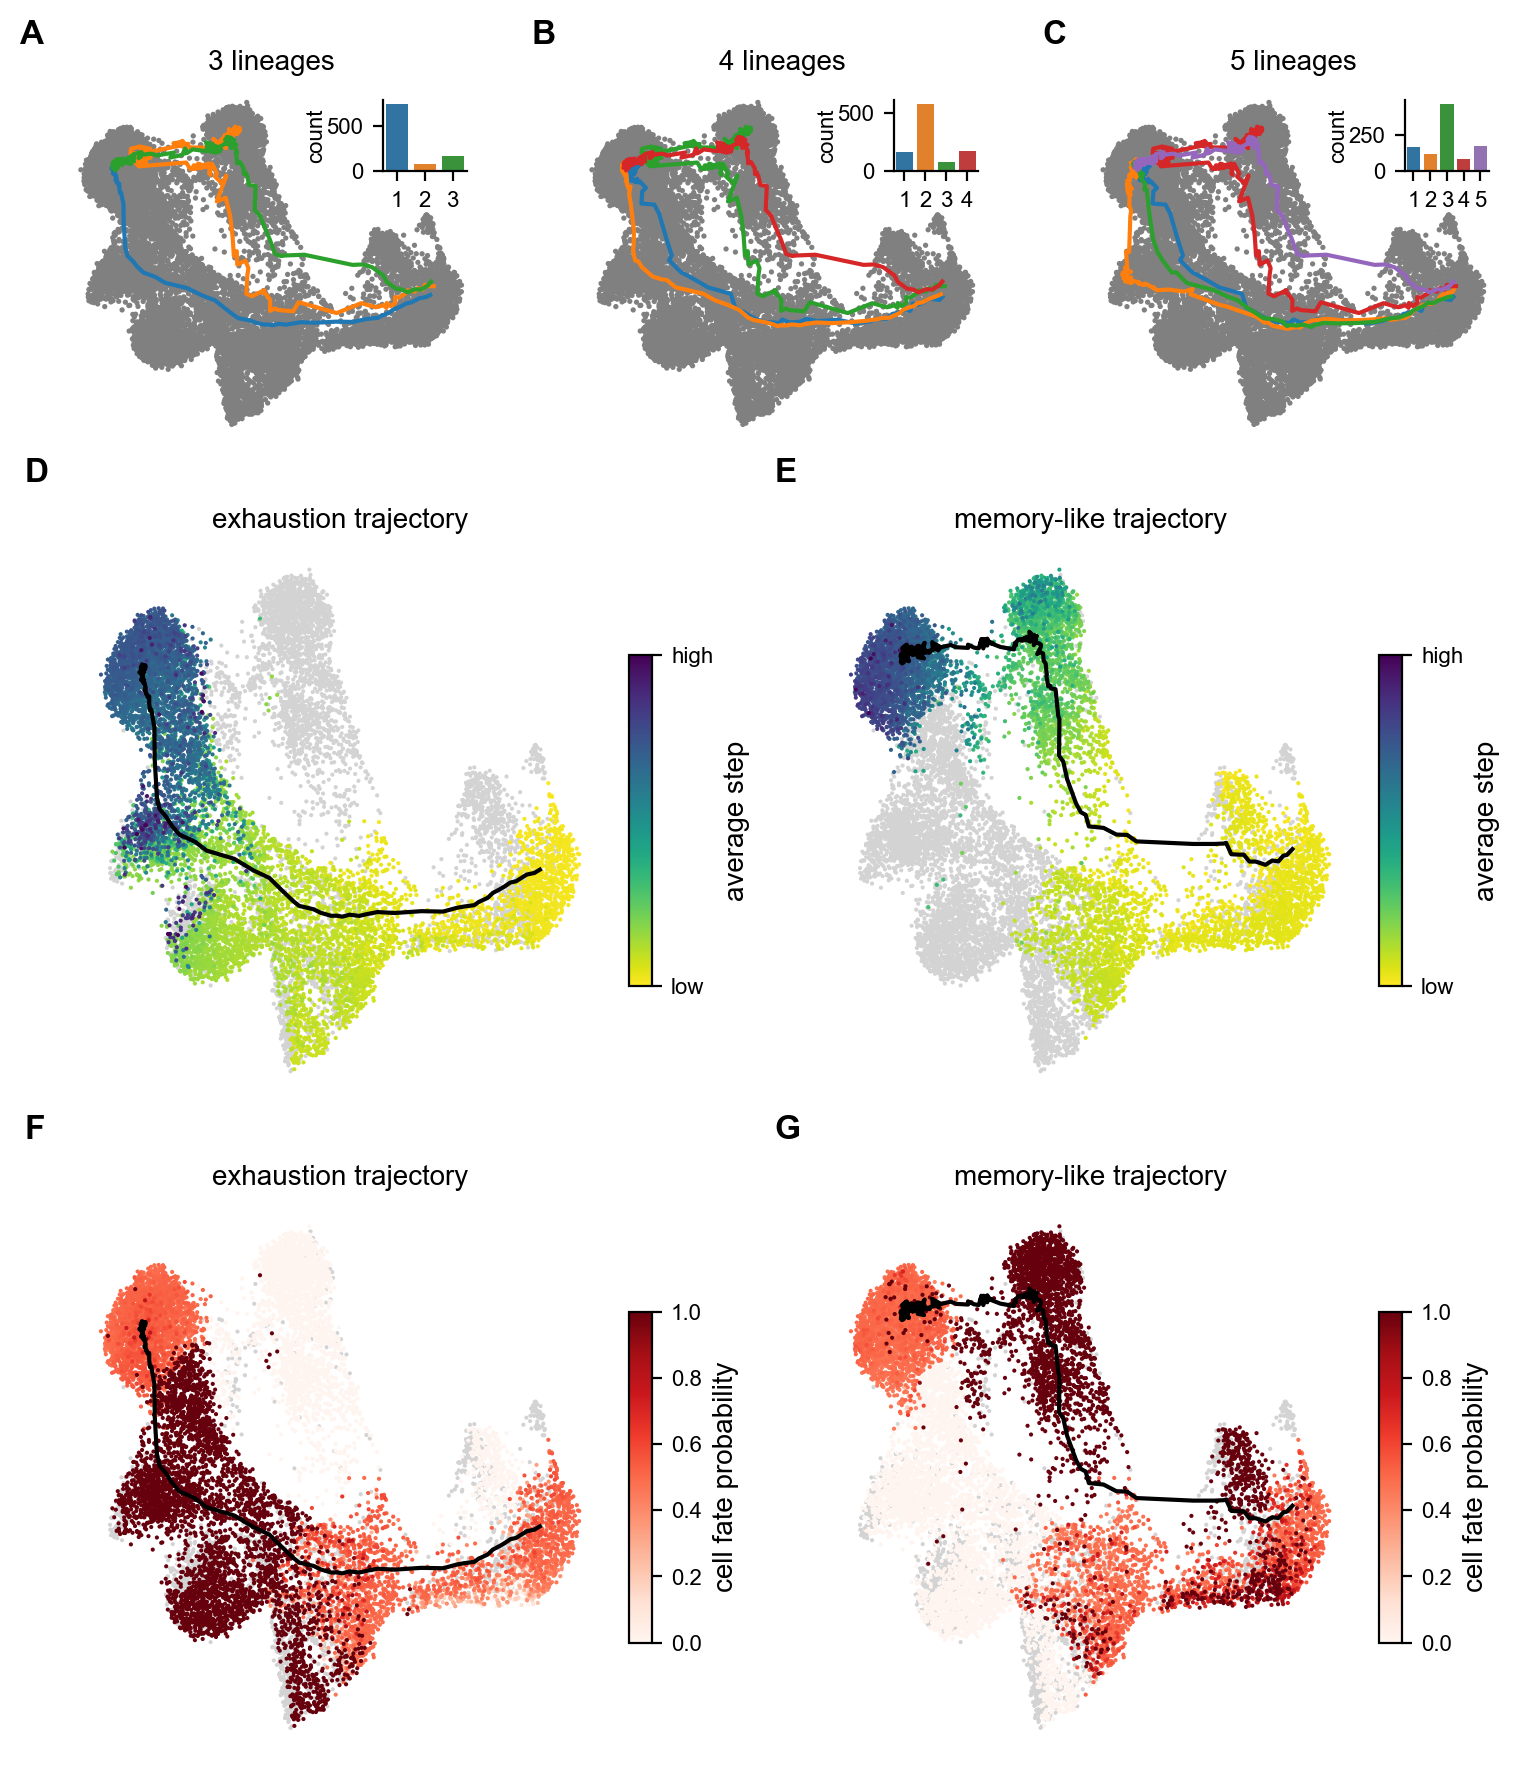

In [29]:
# Fig S7
fig, axs = fig, axs = make_grid((fig_width, fig_width/6*7),
                                {"nrows": 2, "ncols": 1, "row_heights": [2, 6], "col_widths": [1],
                                 "sub_grids": [
                                     {"nrows": 1, "ncols": 3, "row_heights": [1], "col_widths": [1, 1, 1],
                                      "wspace": 0.1},
                                     {"nrows": 2, "ncols": 2, "row_heights": [1, 1], "col_widths": [1, 1]}
                      ]})

# Plot 3-5 lineages
for i, n_lineages in enumerate(range(3, 6)):
    adata_ = c2p.cytopath.infer_cytopath_lineages(adata_c2p, recalc_items=False,
                                                  basis="pca", num_lineages=n_lineages,
                                                  method="linkage", distance_func="dtw",
                                                  differencing=False, copy=True)
    c2p.plot_cytopath_lineages(adata_, basis="umap", ax=axs[i])
    axs[i].set_title(f"{n_lineages} lineages")
    inset_ax = inset_axes(axs[i], width="20%", height="20%", loc=1)
    sns.countplot(x=np.sort(adata_.uns["cytopath"]["lineage_inference_clusters"]).astype(str), ax=inset_ax)
    inset_ax.set_ylabel("count", fontsize=8, labelpad=.1)
    
# Plot step and fate for convergent trajectories
sc.pl.umap(adata_c2p, color="average_step_exh", cmap="viridis_r", ax=axs[3], show=False,
           title="exhaustion trajectory", colorbar_loc=None)
cbar = plt.colorbar(axs[3].get_children()[0], ax=axs[3], shrink=.6, aspect=15, label="average step",
                    ticks=[adata_c2p.obs.average_step_exh.min(), adata_c2p.obs.average_step_exh.max()])
cbar.ax.set_yticklabels(["low", "high"])
axs[3].plot(coords_exh_c2p[:, 0], coords_exh_c2p[:, 1], color="k")

sc.pl.umap(adata_c2p, color="average_step_mem", cmap="viridis_r", ax=axs[4], show=False,
           title="memory-like trajectory", colorbar_loc=None)
cbar = plt.colorbar(axs[4].get_children()[0], ax=axs[4], shrink=.6, aspect=15, label="average step",
                    ticks=[adata_c2p.obs.average_step_mem.min(), adata_c2p.obs.average_step_mem.max()])
cbar.ax.set_yticklabels(["low", "high"])
axs[4].plot(coords_mem_c2p[:, 0], coords_mem_c2p[:, 1], color="k")

sc.pl.umap(adata_c2p, color="fate_prob_exh", cmap="Reds", ax=axs[5], show=False,
           title="exhaustion trajectory", colorbar_loc=None)
plt.colorbar(axs[5].get_children()[0], ax=axs[5], shrink=.6, aspect=15, label="cell fate probability")
axs[5].plot(coords_exh_c2p[:, 0], coords_exh_c2p[:, 1], color="k")

sc.pl.umap(adata_c2p, color="fate_prob_mem", cmap="Reds", ax=axs[6], show=False,
           title="memory-like trajectory", colorbar_loc=None)
plt.colorbar(axs[6].get_children()[0], ax=axs[6], shrink=.6, aspect=15, label="cell fate probability")
axs[6].plot(coords_mem_c2p[:, 0], coords_mem_c2p[:, 1], color="k")

for i, lab in enumerate(string.ascii_uppercase[:7]):
    axs[i].text(-.1, 1.1, lab, transform=axs[i].transAxes, **axlab_kws)

fig.savefig(os.path.join(FIGURE_PATH, "fig_s07.png"))

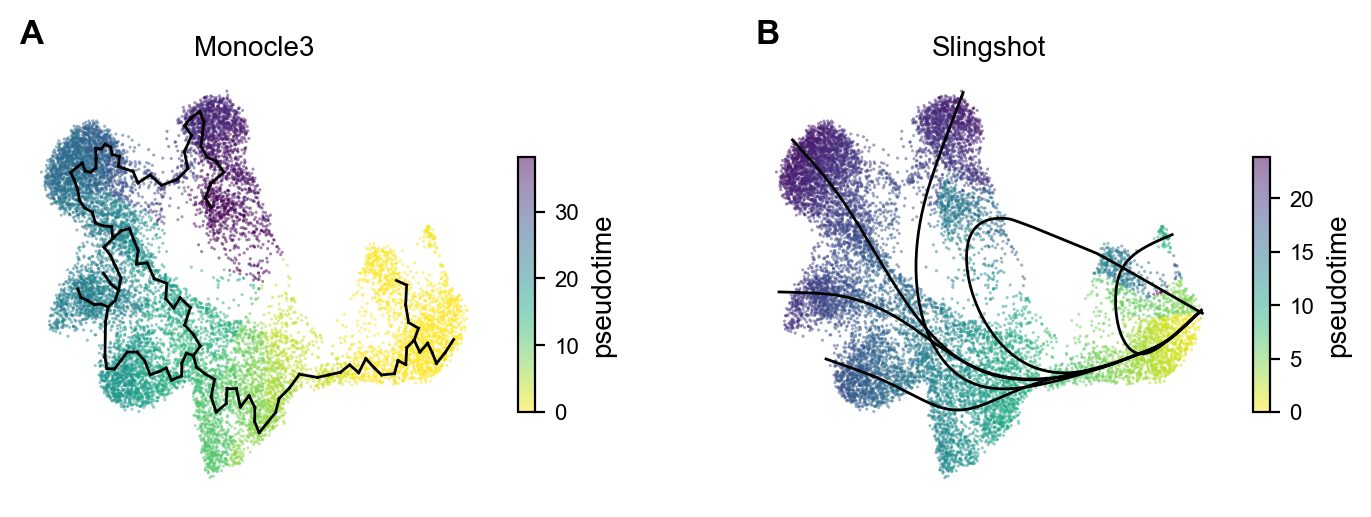

In [30]:
# Fig S8
OUTPUT_PATH = "../output"
# Load monocle results
monocle_pst = pd.read_csv(os.path.join(OUTPUT_PATH, "monocle_pst.csv"), index_col=0)
monocle_graph_coordinates = pd.read_csv(os.path.join(OUTPUT_PATH, "monocle_graph_coordinates.csv"), index_col=0)
monocle_edgelist = pd.read_csv(os.path.join(OUTPUT_PATH, "monocle_graph.csv"), index_col=0)
adata.obs["monocle_pseudotime"] = monocle_pst.Pseudotime.values

# Load slingshot results
slingshot_pst = pd.read_csv(os.path.join(OUTPUT_PATH, "slingshot_pst.csv"), index_col=0)
slingshot_curves = np.load(os.path.join(OUTPUT_PATH, "slingshot_curves.npy"))
adata.obs["slingshot_pseudotime"] = slingshot_pst.Pseudotime.values

fig, axs = plt.subplots(ncols=2, figsize=(fig_width, fig_width/5*2))

# Plot monocle pseudotime and trajectories
sc.pl.umap(adata, color="monocle_pseudotime", title="Monocle3", ax=axs[0], show=False,
           cmap="viridis_r", frameon=False, alpha=.5, colorbar_loc=None, s=5)
plt.colorbar(axs[0].get_children()[0], ax=axs[0], shrink=.6, aspect=15, label="pseudotime")
for source, target in zip(monocle_edgelist.source, monocle_edgelist.target):
    axs[0].plot(monocle_graph_coordinates.iloc[[source, target], 0],
                monocle_graph_coordinates.iloc[[source, target], 1],
                color="k", linewidth=1)
# Plot Slingshot pseudotime and trajectories
sc.pl.umap(adata, color="slingshot_pseudotime", ax=axs[1], show=False, title="Slingshot",
           cmap="viridis_r", frameon=False, alpha=.5, colorbar_loc=None, s=5)
plt.colorbar(axs[1].get_children()[0], ax=axs[1], shrink=.6, aspect=15, label="pseudotime")
for arr in slingshot_curves:
    axs[1].plot(arr[:, 0], arr[:, 1], color="k", linewidth=1)
    
for i, lab in enumerate("AB"):
    axs[i].text(0, 1.05, lab, transform=axs[i].transAxes, **axlab_kws)
fig.savefig(os.path.join(FIGURE_PATH, "fig_s08.png"))
fig.tight_layout();